# LISTEN TO THE SOUNDS OF JERSEY

In [228]:
import sys
import os

import obspy as obs
from obspy.taup import TauPyModel
from obspy.clients.fdsn.client import Client, FDSNNoDataException
from obspy.geodetics.base import calc_vincenty_inverse, kilometer2degrees

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import resampy
import seaborn as sns
import warnings

import IPython.display as ipd
from scipy.io.wavfile import write as wav_write

sns.set_theme(font_scale=1.3)
sns.set_style("ticks")
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["patch.force_edgecolor"] = False
pd.set_option('display.width', 1000)

## Catalog of New Jersey earthquakes

In [229]:
cat = pd.DataFrame(columns=["origin_time_utc", "longitude", "latitude", "depth", "magnitude", "magnitude_type"])
cat.index.name = "event_id"

cat.loc["tewksbury_mainshock", :] = [
    obs.UTCDateTime("2024-04-05T14:23:20"),
    -74.755215,
    40.695936,
    2.6,
    4.8,
    "Mw"
]
cat.loc["tewksbury_aftershock", :] = [
    obs.UTCDateTime("2024-04-05T21:59:14"),
    -74.751417,
    40.697655,
    4.869141,
    3.8,
    "Mw"
]
cat.loc["02_august_2025", :] = [
    obs.UTCDateTime("2025-08-03T02:18:52"),
    -74.051,
    40.854,
    10.0,
    3.0,
    "Mw"
]
cat.loc["05_august_2025", :] = [
    obs.UTCDateTime("2025-08-05T16:11:57"),
    -74.038,
    41.015,
    12.4,
    2.8,
    "mb"
]

cat

,origin_time_utc,longitude,latitude,depth,magnitude,magnitude_type
event_id,,,,,,
tewksbury_mainshock,2024-04-05T14:23:20.000000Z,-74.755215,40.695936,2.6,4.8,Mw
tewksbury_aftershock,2024-04-05T21:59:14.000000Z,-74.751417,40.697655,4.869141,3.8,Mw
02_august_2025,2025-08-03T02:18:52.000000Z,-74.051,40.854,10.0,3.0,Mw
05_august_2025,2025-08-05T16:11:57.000000Z,-74.038,41.015,12.4,2.8,mb


## Download data

In [230]:
# identify seismic station and channel
STATION_CODE = "PAL"
NETWORK_CODE = "LD"
CHANNEL_CODE = "HHZ"
# timing parameters
TIME_BEFORE_P_WAVE_SEC = 5.
DURATION_SEC = 60.
# client to download data
client = Client("IRIS")

In [231]:
# fetch station metadata
station_metadata = client.get_stations(
    network=NETWORK_CODE,
    station=STATION_CODE,
    channel=CHANNEL_CODE,
    starttime=cat["origin_time_utc"].min(),
    endtime=cat["origin_time_utc"].max(),
    level="response",
)
station_metadata

Inventory created at 2025-10-30T15:53:43.084700Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2024-04-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			LD
		Stations (1):
			LD.PAL (Palisades, New York)
		Channels (1):
			LD.PAL..HHZ

In [232]:
SAMPLING_RATE_HZ = station_metadata[0][0][0].sample_rate

In [233]:
# approximate P-wave time arrival with a simple 1D velocity model
model = TauPyModel(model="iasp91")

p_wave_tt = {}

for idx, row in cat.iterrows():
    # calculate distance between event and station
    distance_m, _, _ = calc_vincenty_inverse(
        lat1=row["latitude"],
        lon1=row["longitude"],
        lat2=station_metadata[0][0].latitude,
        lon2=station_metadata[0][0].longitude,
    )
    source_depth = row["depth"]
    # get travel time for P-wave
    arrivals = model.get_travel_times(
        source_depth_in_km=source_depth,
        distance_in_degree=kilometer2degrees(distance_m / 1000.0),
        phase_list=["P", "p"]
    )
    print(arrivals[0])
    p_wave_tt[idx] = arrivals[0].time

p phase arrival at 13.676 seconds
p phase arrival at 13.628 seconds
p phase arrival at 3.962 seconds
p phase arrival at 2.856 seconds


In [234]:
# download the waveforms
seismic_traces = {}
for idx, row in cat.iterrows():
    origin_time = row["origin_time_utc"]
    p_arrival_time = origin_time + p_wave_tt[idx]
    start_time = p_arrival_time - TIME_BEFORE_P_WAVE_SEC
    end_time = start_time + DURATION_SEC

    try:
        st = client.get_waveforms(
            network=NETWORK_CODE,
            station=STATION_CODE,
            location="*",
            channel=CHANNEL_CODE,
            starttime=start_time,
            endtime=end_time,
        )
        st.attach_response(station_metadata)
        st.detrend("linear")
        st.taper(0.05, type="cosine")
        st.remove_response(
            pre_filt=(0.001, 0.005, 45.0, 49.0),
            output="VEL",
            water_level=60,
        )
        seismic_traces[idx] = st[0]
    except FDSNNoDataException:
        warnings.warn(f"No data available for event {idx} at station {STATION_CODE}.")
        continue
seismic_traces[list(seismic_traces.keys())[0]].stats.sampling_rate 

100.0

In [235]:
seismic_traces

{'tewksbury_mainshock': LD.PAL..HHZ | 2024-04-05T14:23:28.678393Z - 2024-04-05T14:24:28.668393Z | 100.0 Hz, 6000 samples,
 'tewksbury_aftershock': LD.PAL..HHZ | 2024-04-05T21:59:22.628394Z - 2024-04-05T22:00:22.618394Z | 100.0 Hz, 6000 samples,
 '02_august_2025': LD.PAL..HHZ | 2025-08-03T02:18:50.968393Z - 2025-08-03T02:19:50.958393Z | 100.0 Hz, 6000 samples,
 '05_august_2025': LD.PAL..HHZ | 2025-08-05T16:11:54.858393Z - 2025-08-05T16:12:54.848393Z | 100.0 Hz, 6000 samples}

Text(0.5, 1.0, 'The Jersey earthquakes recorded at station PAL')

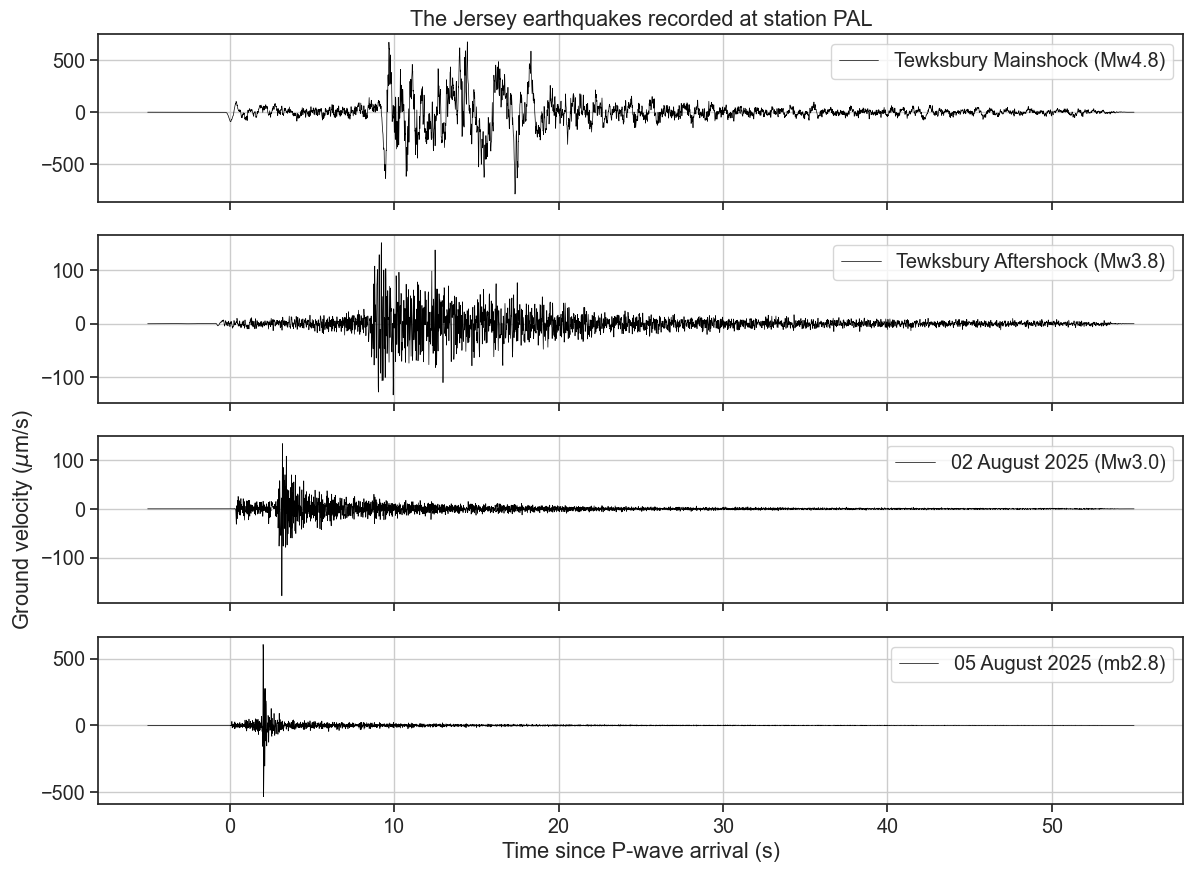

In [236]:
num_events = len(cat)
elapsed_time = np.linspace(
    -TIME_BEFORE_P_WAVE_SEC, DURATION_SEC - TIME_BEFORE_P_WAVE_SEC, int(DURATION_SEC * SAMPLING_RATE_HZ)
    )
gain = 1.e6
fig, axes = plt.subplots(num="seismic_traces_Jersey", nrows=num_events, ncols=1, figsize=(14, 2.5 * num_events), sharex=True)
for i, evid in enumerate(seismic_traces):
    label = evid.replace("_", " ").title()
    label = label + f" ({cat.loc[evid, 'magnitude_type']}{cat.loc[evid, 'magnitude']})"
    axes[i].plot(
        elapsed_time, seismic_traces[evid].data * gain, color="black", lw=0.5, label=label
    )
    axes[i].legend(loc="upper right")
    axes[i].grid()

axes[-1].set_xlabel("Time since P-wave arrival (s)")
axes[num_events // 2].set_ylabel(r"Ground velocity ($\mu$m/s)")

axes[0].set_title(f"The Jersey earthquakes recorded at station {STATION_CODE}")

In [237]:
# fig.savefig(
#     fig.get_label() + ".svg", format="svg", dpi=250, bbox_inches="tight"
# )

## Sonify

### Sonification library

In [238]:
def make_single_wavesound(
    waveform, sampling_rate, speed_factor, audio_sampling_rate, max_amplitude=None
):
    """
    Generate a multi-speaker waveform by resampling and normalizing the input waveform.

    Parameters
    ----------
    waveform : array_like
        The input waveform data.
    sampling_rate : float
        The sampling rate of the input waveform in Hz.
    speed_factor : float
        The factor by which to adjust the speed of the waveform.
    audio_sampling_rate : float
        The desired output sampling rate in Hz.

    Returns
    -------
    tracks : numpy.ndarray
        The generated multi-speaker waveform, with shape (num_speakers, len(data_norm)).
    """
    sampling_rate_accelerated_signal_hz = sampling_rate * speed_factor
    if (
        float(int(sampling_rate_accelerated_signal_hz))
        != sampling_rate_accelerated_signal_hz
    ):
        warnings.warn(
            "Sampling rate * speed_factor cannot be unambigously"
            " interpreted as an integer. It will be rounded down to the"
            " nearest integer."
        )
    sampling_rate_accelerated_signal_hz = int(sampling_rate_accelerated_signal_hz)

    data_resampled = resampy.resample(
        waveform, sampling_rate_accelerated_signal_hz, int(audio_sampling_rate)
    )

    data_norm = normalization(data_resampled, max_amplitude=max_amplitude)

    return data_norm

def normalization(x, max_amplitude=None):
    """Max-normalize the input `x`.

    Parameters
    ----------
    x : numpy.ndarray
        Input to be normalized.

    Returns
    -------
    x_norm : numpy.ndarray
        `x` normalized by its maximum absolute value.
    """
    x = x - x.mean()
    if max_amplitude is None:
        norm = np.abs(x).max()
    else:
        norm = max_amplitude
    if norm > 0.0:
        return np.tanh(x / norm)
    else:
        return x

### Applications

The seismic waves recorded by seismometers are typically not in the audible frequency range ($\sim$ 20Hz - 20,000Hz), and certainly outside of the frequency range humans are most sensitive to ($\sim$ 2,000Hz - 5,000Hz). Instead, seismic waves are made of frequencies that are below the audible range (infrasound). We therefore need to play seismograms at an accelerated time to shift their frequencies up, within the audible range.

As a reference, at these earthquake-station distances and for these small and moderate-size earthquakes, 10Hz is among the most energetic frequencies recorded waves. Thus, speeding up by 44 bring this reference frequency to 440Hz, the musical note $A_4$. 

#### Original amplitude range

In [239]:
SPEED_FACTOR = 44.
# SPEED_FACTOR = 18.
AUDIO_SAMPLING_RATE_HZ = 44100.

In [240]:
tracks = {}
for evid in seismic_traces:
    tracks[evid] = make_single_wavesound(
        seismic_traces[evid].data,
        SAMPLING_RATE_HZ,
        SPEED_FACTOR,
        AUDIO_SAMPLING_RATE_HZ,
    )

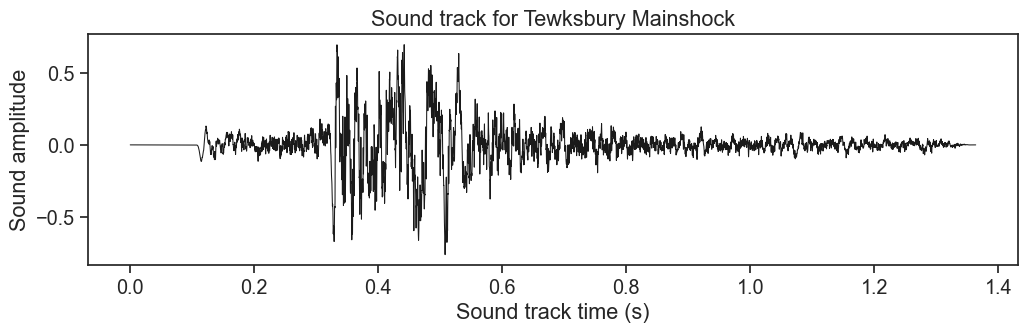

In [241]:
# mainshock
name = "tewksbury_mainshock"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

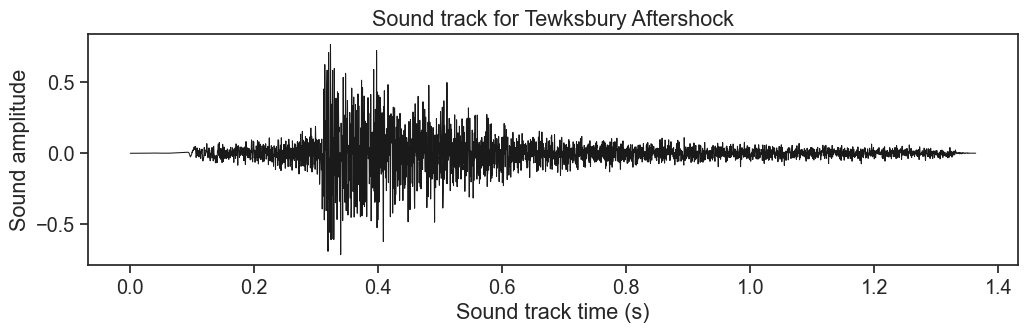

In [242]:
# aftershock
name = "tewksbury_aftershock"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

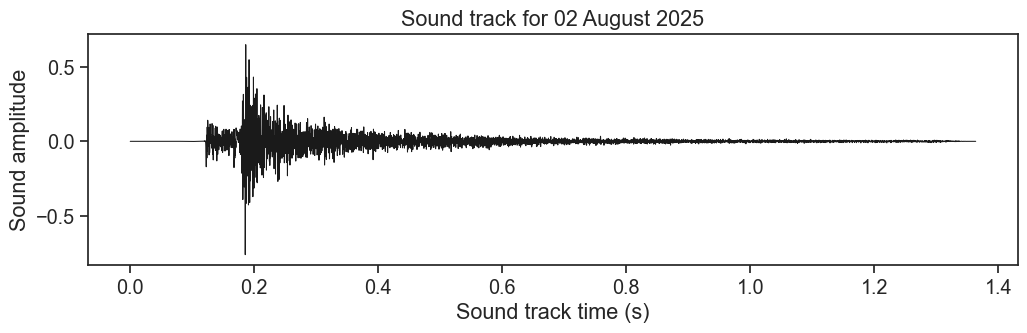

In [243]:
# 02-august-2025 event
name = "02_august_2025"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

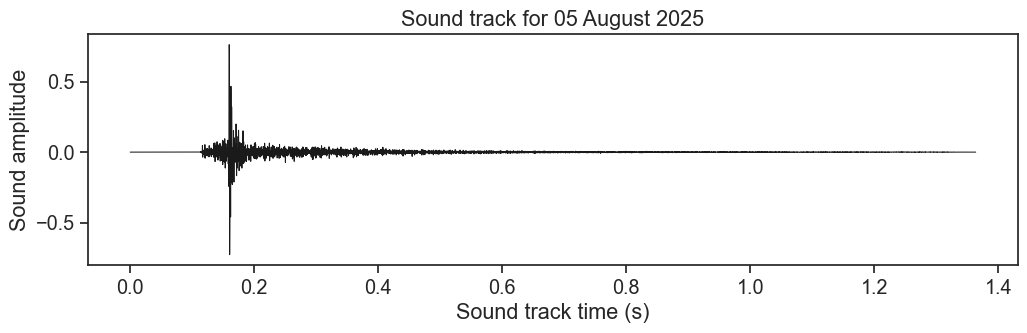

In [244]:
# 05-august-2025 event
name = "05_august_2025"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

In [245]:
# save the tracks to .wav files
if not os.path.exists("output_wav"):
    os.makedirs("output_wav")
for trackname in tracks:
    wav_write(
        os.path.join("output_wav", f"{trackname}_original_amplitude.wav"),
        int(AUDIO_SAMPLING_RATE_HZ),
        tracks[trackname]
        )

### Trimmed amplitude range

In [246]:
SPEED_FACTOR = 44.
# SPEED_FACTOR = 18.
AUDIO_SAMPLING_RATE_HZ = 44100.

In [247]:
tracks = {}
for evid in seismic_traces:
    max_amplitude = seismic_traces[evid].data.max() / 2.
    tracks[evid] = make_single_wavesound(
        seismic_traces[evid].data,
        SAMPLING_RATE_HZ,
        SPEED_FACTOR,
        AUDIO_SAMPLING_RATE_HZ,
        max_amplitude=max_amplitude
    )

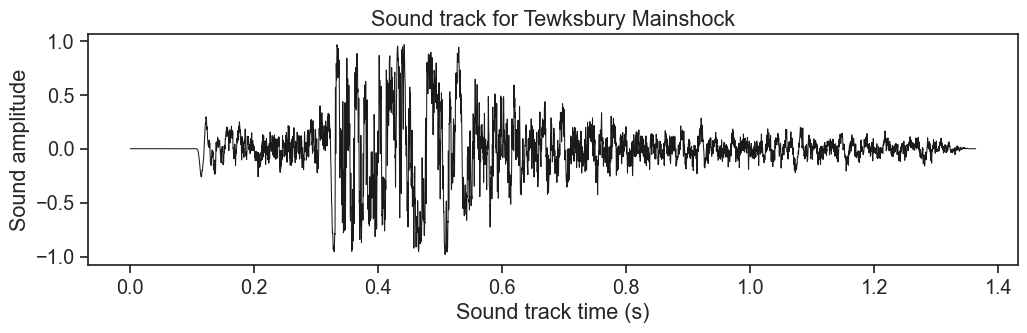

In [248]:
# mainshock
name = "tewksbury_mainshock"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

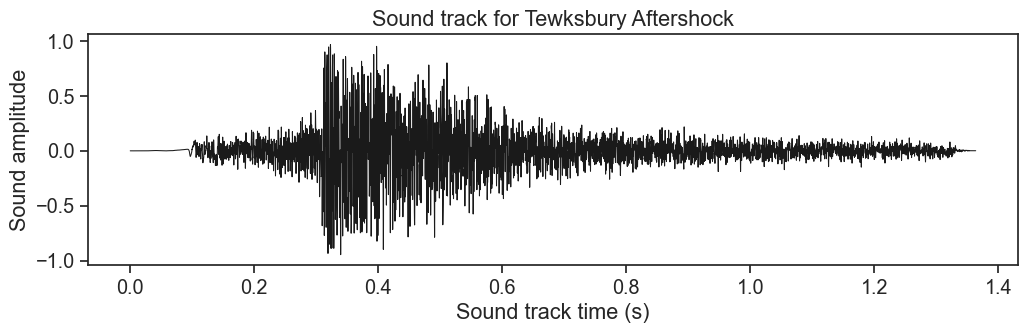

In [249]:
# aftershock
name = "tewksbury_aftershock"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

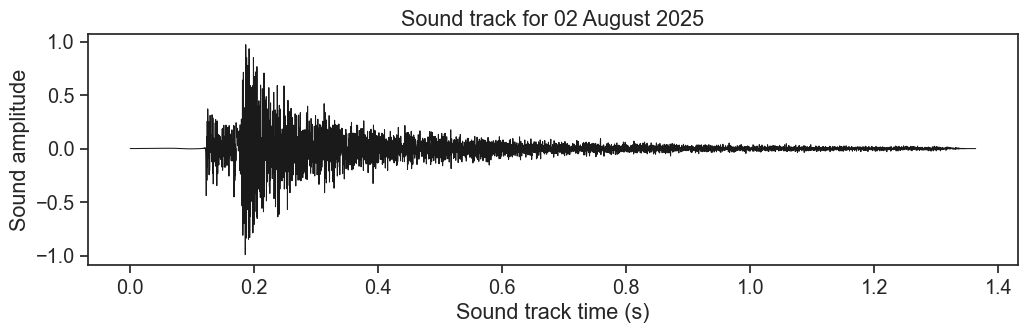

In [250]:
# 02-august-2025 event
name = "02_august_2025"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

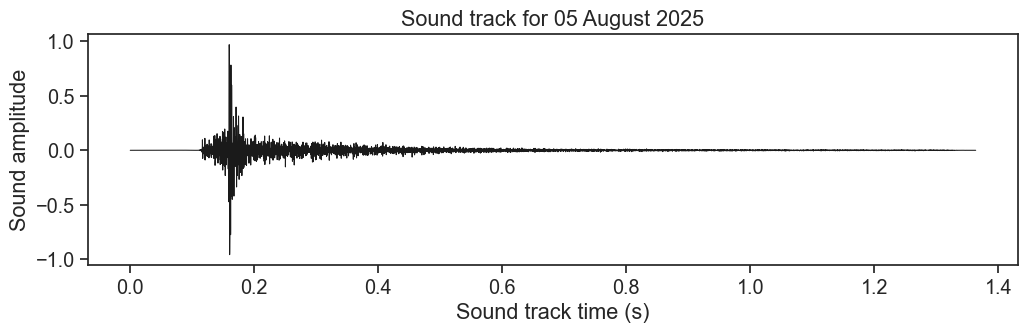

In [251]:
# 05-august-2025 event
name = "05_august_2025"
fig, ax = plt.subplots(num=name, figsize=(12, 3))
time_track = np.arange(len(tracks[name])) / AUDIO_SAMPLING_RATE_HZ
ax.set_title(f"Sound track for {name.replace('_', ' ').title()}")
ax.plot(time_track, tracks[name], lw=0.75, color="k")
ax.set_ylabel("Sound amplitude")
ax.set_xlabel("Sound track time (s)")

ipd.Audio(tracks[name], rate=AUDIO_SAMPLING_RATE_HZ)

In [252]:
# save the tracks to .wav files
if not os.path.exists("output_wav"):
    os.makedirs("output_wav")
for trackname in tracks:
    wav_write(
        os.path.join("output_wav", f"{trackname}_trimmed_amplitude.wav"),
        int(AUDIO_SAMPLING_RATE_HZ),
        tracks[trackname]
        )